# Combine the lipidomics and metabolomics results into one combined dataframe

## Unify column names

## Correlate metabs + lipids filenames for each sample

## Combine with essential metadata

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dateutil
from scipy.stats import pearsonr, kendalltau
from math import isclose
import csv

# Read in metadata

In [9]:
animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic =     [1076, 1082, 1101]
impaired =     [1060, 1062, 1074, 1092, 1102]
normal =       [1091, 1093]
bg_dict = {'diabetic': diabetic, 'impaired': impaired, 'normal': normal}
animal_tol = {
    1076: 'diabetic', 1082: 'diabetic', 1101: 'diabetic', 1060: 'impaired', 1062: 'impaired', 
    1074: 'impaired', 1092: 'impaired', 1102: 'impaired', 1091: 'normal', 1093: 'normal'}
ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# New code starts here

## Read and parse Compound Discoverer exported tables

In [394]:
cd_path = '../data/CD33/Nilerat_metabs_20220516_compounds.csv'
cs_path = '../data/CD33/Nilerat_metabs_20220516_chemspider.csv'

cd_all = pd.read_csv(cd_path)#.to_csv('../data/CD33/CD33_nilerat_metabs.csv')

cs = []
with open(cs_path, encoding='utf-8-sig') as f:
    r = csv.reader(f)
    for line in r:
        cs.append(line)
        
headers = cs[0]
cs_headers = cs[2]

ion_type_index = headers.index('Reference Ion')  # Get index of Reference Ion (e.g. [M+H]+1) in headers
cs_name_index = cs_headers.index('Name')         # Get index of chemspider name

df = []

for i, line in enumerate(cs[1:], start=1):
    cs_names = []
    if '[' in line[ion_type_index]:  # New Compound
        compound_line_index = i
        cs_line_index = compound_line_index + 2
#         print(cs[0])
        try:
            while cs[cs_line_index][1] == 'FALSE':
                cs_names.append(cs[cs_line_index][cs_name_index])
                cs_line_index += 1
        except IndexError:
            pass
        result = {header: entry for header, entry in zip(headers, cs[compound_line_index])}
        if not cs_names:
            cs_names = None
        else:
            cs_names = '\n'.join(cs_names)
        
        result['chemspider_matches'] = cs_names
        df.append(result)
    else:
        continue    
cd = pd.DataFrame(df)

## log2 transform the data
area_cols = cd.filter(regex='Area').columns
cd[area_cols] = cd.loc[:, area_cols].astype('float')
cd.loc[:, area_cols] = np.log2(cd.loc[:, area_cols])
cd

Area (Max.)                                                            float64
Area: 20210831_KAO_HILIC_ACN_20210831232610.raw (F1)                   float64
Area: 20210831_KAO_HILIC_extraction_blank_1.raw (F2)                   float64
Area: 20210831_KAO_HILIC_extraction_blank_1_20210901004002.raw (F3)    float64
Area: 20210831_KAO_HILIC_human_plasma_1.raw (F4)                       float64
                                                                        ...   
Group Area: 20210831_KAO_HILIC_T1102M_20210327_8wk_FBG                 float64
Group Area: 20210831_KAO_HILIC_T1102M_20210402_9wk_FBG                 float64
Group Area: 20210831_KAO_HILIC_T1102M_20210406_9wk_RBG                 float64
Group Area: 20210831_KAO_HILIC_T1102M_20210410_10wk_FBG                float64
Group Area: 20210831_KAO_HILIC_T1102M_20210413_10wk_RBG                float64
Length: 129, dtype: object

,Name,Formula,Annot. Source: Predicted Compositions,Annot. Source: mzCloud Search,Annot. Source: mzVault Search,Annot. Source: ChemSpider Search,Reference Ion,Annot. DeltaMass [ppm],m/z,RT [min],...,Group Area: 20210831_KAO_HILIC_T1101M_20210413_10wk_RBG,Group Area: 20210831_KAO_HILIC_T1102M_20210327_8wk_FBG,Group Area: 20210831_KAO_HILIC_T1102M_20210402_9wk_FBG,Group Area: 20210831_KAO_HILIC_T1102M_20210406_9wk_RBG,Group Area: 20210831_KAO_HILIC_T1102M_20210410_10wk_FBG,Group Area: 20210831_KAO_HILIC_T1102M_20210413_10wk_RBG,# Adducts,mzCloud Library Match: Autoprocessed,mzCloud Library Match: Reference,chemspider_matches
0,Wow! 1082 1076 Piracetam/Ectoine,C6 H10 N2 O2,Full match,No results,No results,Full match,[M-H]-1,-7.31,141.06591,2.353,...,17.433976,16.881903,16.589683,18.479493,18.132105,16.858699,1,No matches found,No matches found,Piracetam\nEctoine\nEctoine
1,Very close mz and RT to Tyrosine but actually ...,C9 H11 N O3,No match,Not the top hit,No results,No results,[M-H]-1,-44.8,180.0585,11.539,...,22.009661,20.786095,20.395097,22.039171,20.757075,21.800102,1,Single match found,Multiple matches found,None
2,Urocanic acid,C6 H6 N2 O2,Full match,Full match,Full match,Partial match,[M+H]+1,-2.71,139.05028,11.365,...,22.863585,23.664396,22.858647,23.627151,24.128623,20.875286,2,Single match found,Multiple matches found,4-Nitroaniline\nUrocanic acid\n2-Aminonicotini...
3,Uridine,C9 H12 N2 O6,Full match,Full match,Full match,Full match,[M-H]-1,-3.02,243.06152,7.513,...,23.863370,25.019023,24.646051,23.802189,24.693756,23.856317,1,No matches found,Single match found,"1-Pentofuranosyl-2,4(1H,3H)-pyrimidinedione\nU..."
4,Uric acid,C5 H4 N4 O3,Full match,Full match,Full match,Full match,[M-H]-1,-5.85,167.02007,12.732,...,26.606979,19.180453,24.860989,27.789178,26.471452,25.842127,2,No matches found,Single match found,"Uric Acid\n5,7-Dihydro-1H-purine-2,6,8(3H)-trione"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,,C12 H16,Full match,Invalid mass,No results,Full match,[M+H]+1,0.34,161.13253,1.403,...,20.180981,20.682412,20.002938,19.871257,19.527316,19.411442,1,Multiple matches found,Single match found,p-Isopropyl-α-methylstyrene\n1-Isopropenyl-3-i...
626,,C12 H10 N2 O S,Not the top hit,No results,No results,Full match,[M-H]-1,-3.14,229.04342,8.657,...,19.210349,21.380531,20.142006,20.730885,21.067634,20.290533,2,No matches found,No matches found,6-Methoxy-3-(2-thiazolyl)-1H-indole
627,,C24 H33 F O6,No match,Full match,No results,Full match,[M+H]+1,5.7,437.23588,1.775,...,19.645897,19.474695,19.493855,18.132069,19.663308,17.140479,1,Multiple matches found,Single match found,"fludroxycortide\n11?,16?,17?,21-tetrahydroxy-9..."
628,,C12 H17 N4 O2 P S,Full match,Invalid mass,No results,No match,[M-H]-1,-6.28,311.07175,9.539,...,15.551615,19.988631,18.609687,17.285504,18.540394,16.588591,1,Single match found,No matches found,diclocymet\nEpithienamycin B\ncarbapenem MM22383


# Parse columns in raw CD input

In [395]:
cd['polarity'] = cd['Reference Ion'].str[-2]
cd['Checked'] = cd['Checked'].map({'TRUE': True, 'FALSE': False})
areas = cd_all.filter(regex='Group').columns
cd[areas] = np.log2(cd[areas].astype('float'))
cd['max_area'] = cd[areas].max(axis=1)
cd['mean'] = cd[areas].mean(axis=1)
cd['is_id'] = (cd['Name'] != '') & (cd['Checked'])
cd['polarity'] = cd['Reference Ion'].apply(lambda x: ('+' if x[-2] == '+' else '-'))
cd[['RT [min]', 'm/z']] = cd[['RT [min]', 'm/z']].astype('float')
cd['Type'] = 'metabolite'

def parse_tags(text):
    output = [
        ('mzCloudID' in text), 
        ('mzVaultID' in text), 
        ('ChemSpiderID' in text),
        ('Lipid' in text), 
        ('11.5' in text),
    ]
    return output
cd['mzcloud'], cd['mzvault'], cd['chemspider'], cd['is_HILIC_lipid'], cd['11.5'] = zip(*cd['Tags'].map(parse_tags))

cd['confident_id'] = ( (cd['mzvault'] | cd['mzcloud']) & \
                      (~cd['is_HILIC_lipid']) & \
                      (cd['Checked']) & \
                      (~cd['Name'].str.contains('drop this duplicate'))
                    )
cd['i'] = ['m_' + str(x) for x in range(cd.shape[0])]

# A tracefinder method was run with metabolite Standards using identical HILIC method
# Correlate the RT and m/z of these Standards to features in Compound Discoverer data to boost IDs and ID confidence 

In [396]:
# Fix the metabolite names to be user-friendly and remove comments
fixed_metab_names = {
    "Adenosine 5'-monophosphate": "Adenosine 5'-monophosphate",
    "Cytidine 5'-diphosphocholine": "Cytidine 5'-diphosphocholine",
    "DL-Carnitine": 'Carnitine',
    "DL-Glutamine": 'Glutamine',
    "DL-Leucine/Isoleucine": 'Leucine/Isoleucine',
    "DL-Lysine": 'Lysine',
    "DL-Proline": 'Proline',
    "Guanosine: all right MS2": 'Guanosine',
    "L-(+)-Arginine": 'Arginine',
    "L-(+)-Citrulline": 'Citrulline',
    "L(+)-Ornithine": 'Ornithine',
    "L-Alanine": 'Alanine',
    "L-Aspartic acid": 'Aspartic acid',
    "L-Glutamic acid": 'Glutamic acid',
    "L-Iditol to Six-carbon sugar alcohol": 'Iditol',
    "L-Phenylalanine": 'Phenylalanine',
    "L-Serine": 'Serine', 
    "L-Tyrosine": 'Tyrosine',
    "L-Valine": 'Valine',
#     "O-Butyryl-L-carnitine": 'Butyryl-L-carnitine',
    "O-Isovaleryl-L-carnitine: rt a little shift": 'Isovalerylcarnitine',
    'O-Butyryl-L-carnitine': 'Butyrylcarnitine',
    'Acetyl-L-carnitine': 'Acetylcarnitine',
    "?-Lactose": 'alpha-Lactose',
    "Xylitol to Arabitol": 'Xylitol',
    '?-Glutamylcysteine': 'Glutamylcysteine',
    'Uridinediphosphateglucose: standard RIAILs study': 'Uridinediphosphateglucose',
#     'Nicotinamide adenine dinucleotide (NAD+)': 'Nicotinamide adenine dinucleotide',
    'L-Pyroglutamic acid': 'Pyroglutamic acid',
    'Citric acid/Isocitric acid': 'Citric acid',
    'D-Hexose 1-phosphate': 'Hexose-1-phosphate',
    'L-Glutathione (reduced)': 'Glutathione',
    'L-2-Aminoadipic acid': '2-Aminoadipic acid',
    'N2-Acetyl-Lysine': 'N2-Acetyllysine',
    'L-Glutathione oxidized': 'Glutathione oxidized',
}
tf_rt_mz = pd.read_csv(r'..\data\interim\Tracefinder_RT_MZ_name.csv', encoding='utf-8', encoding_errors='ignore')
tf_rt_mz = tf_rt_mz.dropna(how='all', axis=1)
tf_rt_mz['Quan Mass'] = tf_rt_mz['Quan Mass'].str.strip(' mz').astype('float')
tf_rt_mz['Compound'] = tf_rt_mz['Compound'].map(fixed_metab_names).fillna(tf_rt_mz['Compound'])
tf_rt_mz = tf_rt_mz.set_index('Compound')
display(tf_rt_mz)

,Quan Mass,RT
Compound,,
Nicotinamide,123.06,2.83
Isovalerylcarnitine,246.17,6.00
Doxycycline,445.16,6.26
Butyrylcarnitine,232.15,7.09
Propionylcarnitine,218.14,7.84
Acetylcarnitine,204.12,8.72
Nicotinic acid,122.02,8.79
Phenylalanine,164.07,9.03
Leucine/Isoleucine,130.09,9.20


In [397]:
def ppm_tol(mz1, mz2, tol=10):
    return abs(mz1 - mz2) / mz1 * 1e6 < tol

cd['tracefinder_id'] = False
for i_cd, mrow in cd.iterrows():
    for compound_name, tfrow in tf_rt_mz.iterrows():
        if ppm_tol(mrow['m/z'], tfrow['Quan Mass'], tol=15) and abs(mrow['RT [min]'] - tfrow['RT']) < 1:
            if compound_name != 'Proline' and compound_name != 'Threonine':  # Threonine and Proline already confirmed
                cd.loc[i_cd, 'Name'] = compound_name
                cd.loc[i_cd, 'tracefinder_id'] = True
            print(mrow['Name'], mrow['m/z'], mrow['RT [min]'], compound_name, tfrow['RT'])

trans-3-Indoleacrylic acid 188.07065 9.866 Indole-3-acrylic acid 9.88
Proline 116.07092 10.143 Proline 10.16
Phenylalanine 164.07068 8.988 Phenylalanine 9.03
N-Acetylalanine 130.04987 11.745 Pyroglutamic acid 12.71
Hexose sugar alcohol 181.07085 10.884 Iditol 11.08
Gluconic acid (drop this duplicate) 195.05013 13.671 Gluconic acid 13.0
Gluconic acid 195.0501 13.121 Gluconic acid 13.0
CAR 5:0 246.16996 5.964 Isovalerylcarnitine 6.0
CAR 3:0 218.13868 7.805 Propionylcarnitine 7.84
Arginine 175.11904 18.052 Arginine 18.06
Alanine 88.0393 11.941 Alanine 11.98
Adenosine monophosphate 348.07031 13.511 Adenosine 5'-monophosphate 12.9
 116.07057 10.182 Proline 10.16
 118.04984 12.041 Threonine 12.12


In [398]:
# Remove any IDs that aren't from mzVault, mzCloud or Tracefinder 
confident_or_tracefinder_id = ~(cd['confident_id'] | cd['tracefinder_id'])
cd['Name'].mask(cond=confident_or_tracefinder_id, inplace=True)

def make_unique_name(name, confident_id, rt, mz):
    if name == '' or not confident_id:
        name = 'unknown_'
    else:
        name += '_'
    return name + str(round(rt, 3)) + '_' + str(mz)
cd['unique_id'] = cd.apply(lambda x: make_unique_name(x['Name'], x['confident_id'], x['RT [min]'], x['m/z']), axis=1)
# cd['unique_id']

# Filter metabolites columns and change column names:

In [399]:
metab_cols_to_keep = [
    'unique_id', 'i', 'RT [min]', 'm/z', 'Reference Ion', 'Type', 'polarity', 'Name', 'is_HILIC_lipid',
    'chemspider_matches',
]
metab_cols_to_keep.extend([col for col in cd.columns if (('Area:' in col) and ('T1' in col) and ('(F' in col))])
cd_filt = cd.loc[:, metab_cols_to_keep]

new_metab_col_names = [col for col in cd_filt.columns if 'Area:' in col]
new_metab_col_names = {col: col.lstrip('Area: ').split('.raw ')[0] for col in new_metab_col_names}
metab_col_name_map = {original: shortened for original, shortened in zip(fg['File Name_metab'], fg.index)}
for key, value in new_metab_col_names.items():
    new_metab_col_names[key] = metab_col_name_map[value]
new_metab_col_names['RT [min]'] = 'RT'
new_metab_col_names['Reference Ion'] = 'adduct'
new_metab_col_names['Name'] = 'ID'

cd_filt.rename(new_metab_col_names, axis=1, inplace=True)

In [400]:
data_cols = cd_filt.filter(regex='RBG|FBG').columns
data_cols


Index(['1102_8_RBG', '1093_9_RBG', '1060_8_FBG', '1060_8_RBG', '1060_9_FBG',
       '1060_9_RBG', '1060_10_FBG', '1060_10_RBG', '1062_8_FBG', '1062_8_RBG',
       '1062_9_FBG', '1062_9_RBG', '1062_10_FBG', '1062_10_RBG', '1074_8_FBG',
       '1074_8_RBG', '1074_9_FBG', '1074_9_RBG', '1074_10_FBG', '1074_10_RBG',
       '1076_8_FBG', '1076_8_RBG', '1076_9_FBG', '1076_9_RBG', '1076_10_FBG',
       '1076_10_RBG', '1082_8_FBG', '1082_8_RBG', '1082_9_FBG', '1082_9_RBG',
       '1082_10_FBG', '1082_10_RBG', '1091_8_FBG', '1091_8_RBG', '1091_9_FBG',
       '1091_9_RBG', '1091_10_FBG', '1091_10_RBG', '1092_10_FBG', '1092_8_FBG',
       '1092_8_RBG', '1092_9_FBG', '1092_9_RBG', '1092_10_RBG', '1093_8_FBG',
       '1093_8_RBG', '1093_9_FBG', '1093_10_FBG', '1093_10_RBG', '1101_8_FBG',
       '1101_8_RBG', '1101_9_FBG', '1101_9_RBG', '1101_10_FBG', '1101_10_RBG',
       '1102_8_FBG', '1102_9_FBG', '1102_9_RBG', '1102_10_FBG', '1102_10_RBG'],
      dtype='object')

# Lipids data 

In [401]:
lipid = pd.read_csv(r'..\data\processed\lipidomics_normalized_filtered_data.csv', index_col=0)
lipid_cols_rename = {value: key for key, value in fg[['fr_name']].to_dict('dict')['fr_name'].items()}
lipid_cols_rename = {
    **lipid_cols_rename,    
    **{'Retention Time (min)': 'RT', 'Polarity': 'polarity', 'Quant Ion': 'm/z',
       'Lipid Class': 'molec_class', 'Identification': 'ID',}}
lipid.rename(lipid_cols_rename, axis=1, inplace=True)

lipid['unique_id'] = lipid.apply(lambda x: make_unique_name(x['ID'], x['is_id'], x['RT'], x['m/z']), axis=1)
lipid['i'] =  ['l_' + str(x) for x in range(fr_filt.shape[0])]
lipid['Type'] = 'lipid'
lipid['is_lipid'] = None
lipid['ID'].replace('unknown', np.nan, inplace=True)

lipid_cols_to_keep = ['unique_id', 'i', 'RT', 'ID', 'm/z', 'polarity', 'Type',] + fg.index.to_list()
lipid = lipid.loc[:, lipid_cols_to_keep]
lipid.reset_index(inplace=True, drop=True)
lipid
# lipid_rawfiles = fg['fr_name']

,unique_id,i,RT,ID,m/z,polarity,Type,1091_8_FBG,1091_9_FBG,1091_10_FBG,...,1102_10_RBG,1076_8_RBG,1076_9_RBG,1076_10_RBG,1082_8_RBG,1082_9_RBG,1082_10_RBG,1101_8_RBG,1101_9_RBG,1101_10_RBG
0,unknown_0.818_622.29077,l_0,0.818,NaN,622.29077,+,lipid,21.152934,20.792085,19.764036,...,19.179026,21.097976,20.299477,20.975292,19.789679,20.425455,19.671902,20.009130,20.903268,20.295132
1,unknown_0.871_453.16891,l_1,0.871,NaN,453.16891,+,lipid,20.022579,20.449339,20.563084,...,19.228641,19.887092,19.577734,19.948040,19.907331,19.706510,19.798125,19.286965,19.996982,19.757995
2,unknown_0.873_645.11963,l_2,0.873,NaN,645.11963,+,lipid,20.308343,20.923962,19.839442,...,19.943100,19.676315,20.121948,20.465764,18.590346,20.817265,20.499134,19.389790,20.034808,20.177499
3,unknown_0.876_631.34955,l_3,0.876,NaN,631.34955,-,lipid,19.701189,19.407521,20.189023,...,18.053283,17.996666,17.640019,17.225795,18.143304,17.539858,18.649412,16.468089,17.961806,17.352706
4,unknown_0.933_376.25961,l_4,0.933,NaN,376.25961,+,lipid,23.896827,23.656997,24.605914,...,23.664533,22.040787,22.410795,22.137962,23.796468,23.861510,22.171940,23.584151,23.881371,25.052195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
868,TG 18:0_18:0_18:0_19.885_908.86542,l_868,19.885,TG 18:0_18:0_18:0,908.86542,+,lipid,19.413597,20.588350,19.899861,...,20.648004,22.595213,22.747233,22.282364,21.439557,22.487249,22.470489,19.315369,20.736354,20.094047
869,unknown_20.144_948.89648,l_869,20.144,NaN,948.89648,+,lipid,16.606829,19.827015,18.266873,...,19.189126,21.091138,21.894233,20.557802,19.559902,21.432017,20.336069,17.516098,19.207749,18.911348
870,unknown_20.148_897.82532,l_870,20.148,NaN,897.82532,+,lipid,19.073429,19.839354,20.133479,...,17.314487,20.100150,19.910734,19.726053,18.755897,19.938896,19.527297,17.607114,18.426683,18.174690
871,unknown_20.175_593.58716,l_871,20.175,NaN,593.58716,+,lipid,19.091184,19.815435,19.996615,...,17.454831,20.120545,20.061485,19.733346,18.693961,19.875737,19.305232,17.541022,18.163185,17.767814


In [402]:
combined = cd_filt.append(lipid)
combined.reset_index(inplace=True, drop=True)
# Re-order columns
# combined = combined[['Type','i','Proposed ID','Tracefinder ID','Lipid Class','m/z',
#                      'RT [min]','Area (Max.)','Score','Adduct','Polarity'] + \
#                       list(metab_rename_dict.values())]
combined.to_csv(r'..\data\interim\interim_combined_metab_lipid_table.csv')
combined

,unique_id,i,RT,m/z,adduct,Type,polarity,ID,is_HILIC_lipid,chemspider_matches,...,1101_8_RBG,1101_9_FBG,1101_9_RBG,1101_10_FBG,1101_10_RBG,1102_8_FBG,1102_9_FBG,1102_9_RBG,1102_10_FBG,1102_10_RBG
0,unknown_2.353_141.06591,m_0,2.353,141.06591,[M-H]-1,metabolite,-,NaN,False,Piracetam\nEctoine\nEctoine,...,16.808717,17.079164,16.351314,17.713890,17.433976,16.881903,16.589683,18.479493,18.132105,16.858699
1,unknown_11.539_180.0585,m_1,11.539,180.05850,[M-H]-1,metabolite,-,NaN,False,None,...,22.170022,20.607768,22.008927,20.527784,22.009661,20.786095,20.395097,22.039171,20.757075,21.800102
2,Urocanic acid_11.365_139.05028,m_2,11.365,139.05028,[M+H]+1,metabolite,+,Urocanic acid,False,4-Nitroaniline\nUrocanic acid\n2-Aminonicotini...,...,22.303258,22.483205,23.273040,23.313011,22.863585,23.664396,22.858647,23.627151,24.128623,20.875286
3,Uridine_7.513_243.06152,m_3,7.513,243.06152,[M-H]-1,metabolite,-,Uridine,False,"1-Pentofuranosyl-2,4(1H,3H)-pyrimidinedione\nU...",...,24.076382,24.319362,23.794484,24.737902,23.863370,25.019023,24.646051,23.802189,24.693756,23.856317
4,Uric acid_12.732_167.02007,m_4,12.732,167.02007,[M-H]-1,metabolite,-,Uric acid,False,"Uric Acid\n5,7-Dihydro-1H-purine-2,6,8(3H)-trione",...,25.684321,26.709748,27.729752,27.103362,26.606979,19.180453,24.860989,27.789178,26.471452,25.842127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498,TG 18:0_18:0_18:0_19.885_908.86542,l_868,19.885,908.86542,NaN,lipid,+,TG 18:0_18:0_18:0,NaN,NaN,...,19.315369,20.166937,20.736354,20.008967,20.094047,20.446792,19.962003,21.260010,20.399305,20.648004
1499,unknown_20.144_948.89648,l_869,20.144,948.89648,NaN,lipid,+,NaN,NaN,NaN,...,17.516098,19.286479,19.207749,16.425442,18.911348,19.510086,18.199582,20.215013,18.965976,19.189126
1500,unknown_20.148_897.82532,l_870,20.148,897.82532,NaN,lipid,+,NaN,NaN,NaN,...,17.607114,19.685160,18.426683,18.108585,18.174690,19.778597,19.199924,19.205373,20.095162,17.314487
1501,unknown_20.175_593.58716,l_871,20.175,593.58716,NaN,lipid,+,NaN,NaN,NaN,...,17.541022,19.526233,18.163185,18.406753,17.767814,19.924372,19.372148,18.938731,20.192346,17.454831


# After writing combined table to .csv file, go to notebooks 3.5.0.X to fit the mixed/fixed effects linear models, then read in those results, and append p-values 

## Important to do this step next so that the 'm_123', 'l_456' shortened indexes stay aligned 

In [405]:
fe = pd.read_csv(r'..\data\interim\mutliomics_fixed_effects_models_results.csv', index_col=0)
fe

,qval_sampling,qval_week,qval_litter,qval_ogtt,qval_sampling:ogtt,qval_insulin,qval_weight,pval_sampling,pval_week,pval_litter,...,model_param_sampling[T.RBG],model_param_week[T.8],model_param_week[T.9],model_param_litter[T.1],model_param_litter[T.2],model_param_litter[T.3],model_param_ogtt,model_param_sampling[T.RBG]:ogtt,model_param_insulin,model_param_weight
i,,,,,,,,,,,,,,,,,,,,,
m_0,4.000984e-01,0.904328,5.250825e-09,0.000134,0.420042,0.073245,0.938720,3.457936e-01,0.821897,3.681261e-11,...,-0.787034,-0.127044,0.097387,2.959985,0.745194,-1.027871,4.380123e-03,0.000655,-0.005820,-0.015089
m_1,7.445629e-10,0.393318,6.740015e-03,0.672509,0.000290,0.998551,0.720189,1.743753e-10,0.209351,1.574016e-03,...,-0.976809,0.238325,0.147832,0.015397,-0.181092,-0.286613,-5.398353e-04,0.001139,0.000345,0.016786
m_2,1.731268e-01,0.309890,4.179124e-01,0.537672,0.796313,0.998551,0.868597,1.353453e-01,0.137982,2.869498e-01,...,-0.056476,0.371453,-0.157067,0.681889,-0.369908,-0.029601,-4.207635e-04,-0.000169,0.000498,-0.019190
m_3,3.708464e-12,0.342502,2.381730e-02,0.064915,0.417686,0.998551,0.200559,6.045068e-13,0.163617,7.842548e-03,...,-0.981715,0.111302,-0.061093,0.554546,-0.268408,0.644351,-2.391706e-04,0.000166,-0.000676,-0.025274
m_4,3.193191e-01,0.008551,4.741950e-01,0.036904,0.243921,0.998551,0.969715,2.668429e-01,0.000131,3.437503e-01,...,-2.837744,-3.827358,-1.050547,-0.987744,-1.850566,-0.369973,-6.659653e-03,0.002223,0.006962,-0.010675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
l_868,8.861385e-03,0.297680,6.026127e-02,0.061292,0.000997,0.998551,0.710381,5.518468e-03,0.128737,2.421677e-02,...,-2.099050,0.177830,0.443024,0.455578,0.494337,-0.112266,4.380724e-04,0.001603,-0.001635,0.027549
l_869,5.265475e-02,0.185237,6.064216e-01,0.506626,0.001014,0.998551,0.609963,3.657456e-02,0.043382,4.652057e-01,...,-3.601004,0.629958,0.874668,-0.264508,0.748834,-0.202775,-3.830995e-04,0.002588,-0.001733,0.055938
l_870,1.520410e-08,0.615372,6.452699e-01,0.228901,0.002078,0.998551,0.878392,4.450968e-09,0.432236,5.111867e-01,...,-4.135453,0.228812,0.308445,0.184192,0.561304,-0.300128,2.548385e-05,0.001666,-0.000870,0.016905


In [431]:
combined_with_pvals = combined.join(fe, on=combined['i']).set_index('unique_id')
combined_with_pvals.loc['unknown_13.671_195.05013', 'ID'] = 'unknown'
combined_with_pvals = combined_with_pvals.loc[combined_with_pvals['is_HILIC_lipid'] != True]
combined_with_pvals = combined_with_pvals.drop(['is_HILIC_lipid', 'chemspider_matches'], axis=1)
combined_with_pvals['ID'].replace(np.nan, 'unknown', inplace=True)
combined_with_pvals.to_csv(r'..\data\processed\combined_metabolites_data_with_model_params.csv')
combined_with_pvals.drop(combined_with_pvals.filter(regex='model_param').columns, axis=1, inplace=True)
combined_with_pvals

,i,RT,m/z,adduct,Type,polarity,ID,1102_8_RBG,1093_9_RBG,1060_8_FBG,...,qval_sampling:ogtt,qval_insulin,qval_weight,pval_sampling,pval_week,pval_litter,pval_ogtt,pval_sampling:ogtt,pval_insulin,pval_weight
unique_id,,,,,,,,,,,,,,,,,,,,,
unknown_2.353_141.06591,m_0,2.353,141.06591,[M-H]-1,metabolite,-,unknown,16.861652,16.671317,17.594730,...,0.420042,0.073245,0.938720,3.457936e-01,0.821897,3.681261e-11,4.447250e-07,0.302665,0.000069,0.745519
unknown_11.539_180.0585,m_1,11.539,180.05850,[M-H]-1,metabolite,-,unknown,22.144573,20.963399,20.198771,...,0.000290,0.998551,0.720189,1.743753e-10,0.209351,1.574016e-03,4.903988e-01,0.000013,0.470022,0.335495
Urocanic acid_11.365_139.05028,m_2,11.365,139.05028,[M+H]+1,metabolite,+,Urocanic acid,22.576981,23.843259,23.895235,...,0.796313,0.998551,0.868597,1.353453e-01,0.137982,2.869498e-01,3.198128e-01,0.720019,0.636623,0.579999
Uridine_7.513_243.06152,m_3,7.513,243.06152,[M-H]-1,metabolite,-,Uridine,23.803795,24.316310,24.714910,...,0.417686,0.998551,0.200559,6.045068e-13,0.163617,7.842548e-03,1.173282e-02,0.299778,0.041686,0.034542
Uric acid_12.732_167.02007,m_4,12.732,167.02007,[M-H]-1,metabolite,-,Uric acid,24.596731,26.201371,17.148994,...,0.243921,0.998551,0.969715,2.668429e-01,0.000131,3.437503e-01,5.418906e-03,0.142652,0.033989,0.922902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TG 18:0_18:0_18:0_19.885_908.86542,l_868,19.885,908.86542,NaN,lipid,+,TG 18:0_18:0_18:0,20.930734,20.351041,20.999142,...,0.000997,0.998551,0.710381,5.518468e-03,0.128737,2.421677e-02,1.080670e-02,0.000097,0.052741,0.326425
unknown_20.144_948.89648,l_869,20.144,948.89648,NaN,lipid,+,unknown,19.535142,19.313450,19.774817,...,0.001014,0.998551,0.609963,3.657456e-02,0.043382,4.652057e-01,2.821484e-01,0.000101,0.207800,0.219332
unknown_20.148_897.82532,l_870,20.148,897.82532,NaN,lipid,+,unknown,18.104875,18.387917,20.517490,...,0.002078,0.998551,0.878392,4.450968e-09,0.432236,5.111867e-01,8.284913e-02,0.000314,0.358879,0.595066


In [432]:
combined_with_pvals.to_csv(r'..\data\processed\combined_metabolites_data.csv')
combined_with_pvals.to_excel(r'..\data\processed\combined_metabolites_data.xlsx')

# Below is old, obsolete code

In [4]:
####### Animal phenotypes/metadata

animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic = [1076, 1082, 1101]
impaired = [1060, 1062, 1074, 1092, 1102]
normal = [1091, 1093]
bg_dict = {'diabetic': diabetic, 'impaired': impaired, 'normal': normal}
animal_to_tolerance_dict = {1076: 'diabetic', 1082: 'diabetic',1101: 'diabetic',
                            1060: 'impaired', 1062: 'impaired', 1074: 'impaired', 1092: 'impaired', 1102: 'impaired', 
                            1091: 'normal', 1093: 'normal',}

obs = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='cleaned')
obs['animal'] = obs['animal'].str.strip('TM').astype('int')
obs['datetime'] = obs['when'].apply(dateutil.parser.parse)
animal_phenotypes = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='animal phenotypes')
animal_phenotypes['animal'] = animal_phenotypes['animal'].str.strip('TM').astype('int')

####### Lipidomics data
# fr_filt is the pre-processed and filtered dataset
fr_filt = pd.read_csv(r'..\data\processed\lipidomics_normalized_filtered_data.csv', index_col=0)
lfg = pd.read_csv(r'..\data\metadata\file_grouping.csv', index_col=0)  # lfg = lipid file grouping
fr_rawfiles = lfg[lfg['quant_file'] == True]['fr_name'].to_list()

####### Metabolomics data from Tracefinder and Compound Discoverer 3.3
mfg = pd.read_csv(r'..\data\metadata\metabolomics_file_grouping.csv', index_col=0)  # mfg = metabolomics file grouping
tf = pd.read_excel(r'..\data\raw\metabolomics\20210904_KAO_Huishi_HILIC_Tracefinder_peakAreas.xlsx', index_col=0)
tf_metab_cols = tf.columns
tf_quant_filenames = mfg[mfg['quant_file'] == True]['File Name'].to_list()
# tf = tf.replace(0, 100)  # REPLACING ZEROES WITH 1E3

In [5]:
fg = lfg.rename({'rat_label':'animal'}, axis=1).reset_index()
fg = fg[fg['quant_file'] == True].merge(mfg, 
                    left_on=['animal', 'bg_type', 'week', 'quant_file'],
                    right_on=['animal', 'bg_type', 'week', 'quant_file'],
                    suffixes=('_lipid', '_metab'))
fg['animal'] = fg['animal'].astype('int')
fg['week'] = fg['week'].astype('int')
fg.rename({'analytical_run_order': 'lipid_run_order', 'analytical_order': 'metab_run_order'}, axis=1, inplace=True)
fg['combined_col_name'] = fg['animal'].astype('str') + '_' + fg['week'].astype('str') + '_' + fg['bg_type']
# fg.to_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv')
fg

,File Name_lipid,lipid_run_order,fr_name,animal,bg_type,quant_file,week,lipidex_file_number,date,glucose_tolerance,bg,File Name_metab,metab_run_order,fixed_filename,qc_file,blank_file,gluc_tol,combined_col_name
0,20210729_AJ_Toh_RatBloodGlucose_T1076M_2021040...,7,20210729_AJ_Toh_RatBloodGlucose_T1076M_2021040...,1076,FBG,True,10,27,2021-04-05,diabetic,71.000000,20210831_KAO_HILIC_T1076M_20210405_10wk_FBG,21,20210831_KAO_HILIC_T1076M_20210405_10wk_FBG,False,False,diabetic,1076_10_FBG
1,20210729_AJ_Toh_RatBloodGlucose_T1062M_2021032...,8,20210729_AJ_Toh_RatBloodGlucose_T1062M_2021032...,1062,FBG,True,8,9,2021-03-22,impaired,52.333333,20210831_KAO_HILIC_T1062M_20210322_8wk_FBG,61,20210831_KAO_HILIC_T1062M_20210322_8wk_FBG,False,False,impaired,1062_8_FBG
2,20210729_AJ_Toh_RatBloodGlucose_T1093M_2021040...,9,20210729_AJ_Toh_RatBloodGlucose_T1093M_2021040...,1093,FBG,True,9,49,2021-04-02,normal,64.000000,20210831_KAO_HILIC_T1093M_20210402_9wk_FBG,50,20210831_KAO_HILIC_T1093M_20210402_9wk_FBG,False,False,normal,1093_9_FBG
3,20210729_AJ_Toh_RatBloodGlucose_T1060M_2021032...,10,20210729_AJ_Toh_RatBloodGlucose_T1060M_2021032...,1060,RBG,True,8,4,2021-03-25,impaired,225.000000,20210831_KAO_HILIC_T1060M_20210325_8wk_RBG,59,20210831_KAO_HILIC_T1060M_20210325_8wk_RBG,False,False,impaired,1060_8_RBG
4,20210729_AJ_Toh_RatBloodGlucose_T1091M_2021041...,11,20210729_AJ_Toh_RatBloodGlucose_T1091M_2021041...,1091,FBG,True,10,39,2021-04-10,normal,48.500000,20210831_KAO_HILIC_T1091M_20210410_10wk_FBG,56,20210831_KAO_HILIC_T1091M_20210410_10wk_FBG,False,False,normal,1091_10_FBG
5,20210729_AJ_Toh_RatBloodGlucose_T1092M_2021040...,12,20210729_AJ_Toh_RatBloodGlucose_T1092M_2021040...,1092,RBG,True,9,44,2021-04-06,impaired,70.500000,20210831_KAO_HILIC_T1092M_20210406_9wk_RBG,18,20210831_KAO_HILIC_T1092M_20210406_9wk_RBG,False,False,impaired,1092_9_RBG
6,20210729_AJ_Toh_RatBloodGlucose_T1093M_2021041...,13,20210729_AJ_Toh_RatBloodGlucose_T1093M_2021041...,1093,RBG,True,10,52,2021-04-13,normal,69.500000,20210831_KAO_HILIC_T1093M_20210413_10wk_RBG,45,20210831_KAO_HILIC_T1093M_20210413_10wk_RBG,False,False,normal,1093_10_RBG
7,20210729_AJ_Toh_RatBloodGlucose_T1082M_2021040...,14,20210729_AJ_Toh_RatBloodGlucose_T1082M_2021040...,1082,FBG,True,10,33,2021-04-05,diabetic,50.000000,20210831_KAO_HILIC_T1082M_20210405_10wk_FBG,41,20210831_KAO_HILIC_T1082M_20210405_10wk_FBG,False,False,diabetic,1082_10_FBG
8,20210729_AJ_Toh_RatBloodGlucose_T1060M_2021040...,15,20210729_AJ_Toh_RatBloodGlucose_T1060M_2021040...,1060,RBG,True,9,6,2021-04-01,impaired,83.000000,20210831_KAO_HILIC_T1060M_20210401_9wk_RBG,5,20210831_KAO_HILIC_T1060M_20210401_9wk_RBG,False,False,impaired,1060_9_RBG
9,20210729_AJ_Toh_RatBloodGlucose_T1101M_2021040...,16,20210729_AJ_Toh_RatBloodGlucose_T1101M_2021040...,1101,FBG,True,9,55,2021-04-02,diabetic,43.000000,20210831_KAO_HILIC_T1101M_20210402_9wk_FBG,44,20210831_KAO_HILIC_T1101M_20210402_9wk_FBG,False,False,diabetic,1101_9_FBG


### Merged df will have column names with "animal_week_bg"
### Row will have shortened name with "m_[index]" for metabolites, and "l_[index]" for lipids
### Index will be unique identifier with ID_MZ_RT format

## Modifying metabolites DF for collaborator sharing

## Correlate the 30 IDs from tracefinder with the peaks in CD 3.3 output

In [6]:
fixed_metab_names = {
#     "Acetyl-L-carnitine": 'Acetyl-L-carnitine',
    "Adenosine 5'-monophosphate": "Adenosine 5'-monophosphate",
    "Cytidine 5'-diphosphocholine": "Cytidine 5'-diphosphocholine",
    "DL-Carnitine": 'Carnitine',
    "DL-Glutamine": 'Glutamine',
    "DL-Leucine/Isoleucine": 'Leucine/Isoleucine',
    "DL-Lysine": 'Lysine',
    "DL-Proline": 'Proline',
    "Guanosine: all right MS2": 'Guanosine',
    "L-(+)-Arginine": 'L-Arginine',
    "L-(+)-Citrulline": 'L-Citrulline',
    "L(+)-Ornithine": 'L-Ornithine',
    "L-Alanine": 'L-Alanine',
    "L-Aspartic acid": 'L-Aspartic acid',
    "L-Glutamic acid": 'L-Glutamic acid',
    "L-Iditol to Six-carbon sugar alcohol": 'Iditol',
    "L-Phenylalanine": 'L-Phenylalanine',
    "L-Serine": 'L-Serine', 
    "L-Tyrosine": 'L-Tyrosine',
    "L-Valine": 'L-Valine',
#     "O-Butyryl-L-carnitine": 'Butyryl-L-carnitine',
    "O-Isovaleryl-L-carnitine: rt a little shift": 'O-Isovaleryl-L-carnitine',
    "?-Lactose": 'alpha-Lactose',
    "Xylitol to Arabitol": 'Xylitol/Arabitol',
    '?-Glutamylcysteine': 'Glutamylcysteine',
    'Uridinediphosphateglucose: standard RIAILs study': 'Uridinediphosphateglucose',
    'Nicotinamide adenine dinucleotide (NAD+)': 'Nicotinamide adenine dinucleotide',
}
tf_rt_mz = pd.read_csv(r'..\data\interim\Tracefinder_RT_MZ_name.csv', encoding='utf-8', encoding_errors='ignore')
tf_rt_mz = tf_rt_mz.dropna(how='all', axis=1)
tf_rt_mz['Quan Mass'] = tf_rt_mz['Quan Mass'].str.strip(' mz').astype('float')
# tf_rt_mz = tf_rt_mz.set_index('Compound')
tf_rt_mz['Compound'] = tf_rt_mz['Compound'].map(fixed_metab_names).fillna(tf_rt_mz['Compound'])

tf_rt_mz = tf_rt_mz.set_index('Compound')
tf_rt_mz

,Quan Mass,RT
Compound,,
Nicotinamide,123.06,2.83
O-Isovaleryl-L-carnitine,246.17,6.00
Doxycycline,445.16,6.26
O-Butyryl-L-carnitine,232.15,7.09
Propionylcarnitine,218.14,7.84
Acetyl-L-carnitine,204.12,8.72
Nicotinic acid,122.02,8.79
L-Phenylalanine,164.07,9.03
Leucine/Isoleucine,130.09,9.20


In [7]:
def replace_unsafe_chars(row):
    if (row['Proposed ID'] == 'nan'):
        s = 'unknown'
    else: 
        s = str(row['Proposed ID'])
#         for char in ["'", '(', ')', '+', ',', '-', ':', ';', '?', '[', ']', '�', '{', '}', '/']:
        for char in ['?', '�', '�']:
            s = s.replace(char, '')
        s = s.replace('_', '-')
    s = row['RT [min]'] + '_' + \
        str(round(float(row['m/z']), 3)) + '_' + s 
    return s

In [8]:
metab = pd.read_csv(r'..\data\processed\CD33_metabs_manual_curated.csv', encoding='utf-8', encoding_errors='ignore')
# Filter rows for only Compounds table by checking for NaN in first column
metab = metab.loc[metab[metab.columns[0]].notna()]
metab = metab.dropna(how='all', axis=1)  # Drop columns that are all NaN

cols = metab.columns
pr_cols = metab.filter(regex='Peak Rating')  # pr == Peak Rating 
pr_sample_cols = pr_cols.filter(regex='BG').columns
pr_sample_cols
rawfile_cols = metab.filter(regex='Group Area').columns
# Rename the columns to remove "Group Area: " from each quant col
renamed_rawfile_cols = {col: col.lstrip('Group Area: ') for col in rawfile_cols}
metab = metab.rename(renamed_rawfile_cols, axis=1)
# sample_cols = metab.filter(regex='Group Area').filter(regex='BG').columns
rawfile_cols = list(renamed_rawfile_cols.values())

# Log2 transform data
metab.loc[:, list(rawfile_cols) + ['Area (Max.)']] = np.log2(metab.loc[:, list(rawfile_cols) + ['Area (Max.)']].astype('float'))  
# During manual curation, BAD features were CHECKED == TRUE.
# So GOOD FEATURES have CHECKED == FALSE
metab = metab[metab['Checked'] == 'FALSE']
metab = metab.reset_index(drop=True)
metab['i'] = 'm_' + metab.index.astype('str')  # gives each row a "m_456" label
metab['mzCloud Best Match'] = metab['mzCloud Best Match'].astype('float')
metab['Name'] = metab['Name'].astype('str')
metab['Name'] = metab['Name'].str.replace('nan', 'unknown')
metab['Polarity'] = metab['Reference Ion'].str[-2]
  
metab_rename_dict = fg[['File Name_metab', 'combined_col_name']].set_index('File Name_metab').T.to_dict('records')[0]
metab.rename(metab_rename_dict, axis=1, inplace=True)
metab = metab[['i', 'Name', 'm/z', 'RT [min]', 'Area (Max.)',
               'mzCloud Best Match', 'Reference Ion', 'Polarity'] + \
               list(metab_rename_dict.values())]
metab.rename({'Name': 'Proposed ID', 'Reference Ion': 'Adduct', 'mzCloud Best Match': 'Score'}, axis=1, inplace=True)
metab['Type'] = 'metabolite'

metab.loc[(metab['Score'] < 80) | (metab['Score'].isna()), 'Proposed ID'] = 'unknown'

################  Tracefinder correlation   ##############
matches = []
for i, row in metab[['RT [min]', 'm/z']].iterrows():
    for tf, tfrow in tf_rt_mz.iterrows():
        if isclose(float(row['m/z']), tfrow['Quan Mass'], rel_tol=100*1e-6, abs_tol=0) and \
           isclose(float(row['RT [min]']), tfrow['RT'], rel_tol=0, abs_tol=0.5):
            matches.append((i, tf, float(row['m/z']), tfrow['Quan Mass'], float(row['RT [min]']), tfrow['RT']))
tf_matches = pd.DataFrame(matches, columns=['CD_ID', 'TF_ID', 'CD_mz', 'TF_mz', 'CD_RT', 'TF_RT'])
tf_matches
metab['Tracefinder ID'] = np.nan
for i, match in tf_matches.iterrows():
    metab.loc[match['CD_ID'], 'Tracefinder ID'] = match['TF_ID']
    metab.loc[match['CD_ID'], 'Proposed ID'] = match['TF_ID']
    metab.loc[match['CD_ID'], 'Score'] = 'Tracefinder confirmed'

# Set unique ID 
metab.index = metab.apply(lambda row: replace_unsafe_chars(row), axis=1)

# Drop columns with 'PEG' (polyethyleneglycol is usually junk) 
#     or 'Ethylenediaminetetraaceticacid' (EDTA used in plasma processing)
metab = metab.loc[~metab['Proposed ID'].str.contains('PEG')]
metab = metab.loc[~metab['Proposed ID'].str.contains('Ethylenediaminetetraacetic')]
metab

,i,Proposed ID,m/z,RT [min],Area (Max.),Score,Adduct,Polarity,1076_10_FBG,1062_8_FBG,...,1062_8_RBG,1102_10_FBG,1093_8_RBG,1074_9_FBG,1062_9_RBG,1101_8_RBG,1092_8_RBG,1092_10_RBG,Type,Tracefinder ID
16.616_141.016_unknown,m_0,unknown,141.01586,16.616,31.253941,NaN,[M-H]-1,-,29.163795,30.572489,...,30.636650,30.699123,30.766149,30.497881,30.660280,30.612707,30.631697,30.794926,metabolite,NaN
1.591_279.232_Linoleic Acid,m_1,Linoleic Acid,279.23234,1.591,30.736789,99.2,[M-H]-1,-,30.152274,30.703658,...,30.109212,30.203473,29.407519,30.130298,29.755386,29.830917,29.260529,29.010637,metabolite,NaN
2.597_496.34_unknown,m_2,unknown,496.33981,2.597,30.704673,NaN,[M+H]+1,+,29.735454,29.569621,...,30.189935,29.744298,29.968890,29.847046,29.784137,29.933457,29.709495,29.593597,metabolite,NaN
1.568_281.248_trans-Petroselinic acid,m_3,trans-Petroselinic acid,281.24793,1.568,30.641931,100.0,[M-H]-1,-,29.701370,30.641931,...,29.492769,29.923218,28.537792,30.129041,29.130426,29.104520,28.779871,28.319689,metabolite,NaN
12.732_167.02_Uric acid,m_4,Uric acid,167.02007,12.732,30.533544,88.4,[M-H]-1,-,26.700629,21.774699,...,26.822243,26.471452,24.519750,24.755634,27.438915,25.684321,17.121551,24.795886,metabolite,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10.503_395.182_unknown,m_700,unknown,395.1822,10.503,20.436330,NaN,[M+H]+1,+,19.195914,19.345424,...,19.619823,19.818652,19.224277,19.415337,19.566293,19.672762,19.911585,18.385167,metabolite,NaN
14.755_390.952_unknown,m_701,unknown,390.95192,14.755,20.407732,NaN,[M-H]-1,-,19.182983,19.717326,...,19.575585,19.760808,19.533956,19.677876,19.475471,19.596183,19.838298,19.657482,metabolite,NaN
12.712_334.976_unknown,m_702,unknown,334.97585,12.712,20.292888,NaN,[M+H]+1,+,19.957869,19.888199,...,18.929660,19.841179,18.530340,19.346356,19.507276,18.904319,19.089163,17.976150,metabolite,NaN
11.722_343.165_unknown,m_703,unknown,343.16453,11.722,20.258819,NaN,[M+H]+1,+,19.830616,19.854122,...,18.940518,19.944687,19.839130,19.853864,19.091589,19.290090,19.106805,18.510999,metabolite,NaN


In [9]:
metab.loc[metab['Proposed ID'] != 'unknown', 'Proposed ID'].to_list()

['Linoleic Acid',
 'trans-Petroselinic acid',
 'Uric acid',
 'Stearic acid',
 'Docosahexaenoic Acid',
 'NP-012534',
 'Octabenzone',
 'DL-Lactic Acid',
 'N,N-Diethylethanolamine',
 'Palmitoyl sphingomyelin',
 'Glutamine',
 'Choline',
 'Betaine',
 '1-Phenyl-1H-pyrazolo[3,4-d]pyrimidin-4-amine',
 'Ostruthin',
 'Myristyl sulfate',
 'cis-7-Hexadecenoic acid',
 '2-Ethylhexanoic acid',
 '13(S)-HOTrE',
 'Creatine',
 '(+/-)12(13)-DiHOME',
 '16-Hydroxyhexadecanoic acid',
 '()9-HpODE',
 'Valdecoxib',
 'Acetyl-L-carnitine',
 'Creatinine',
 'N,N-Diisopropylethylamine (DIPEA)',
 'Decanoic acid',
 'Leucine/Isoleucine',
 'Nounknownoic acid',
 '3-Hydroxybutyric acid',
 'NP-004768',
 '2-Mercaptoethanol',
 'D-(+)-Glucose',
 'Triethanolamine',
 '5-Aminovaleric acid',
 'L-(+)-Lactic acid',
 'all-cis-4,7,10,13,16-Docosapentaenoic acid',
 'N-Methyl-2-pyrrolidone',
 'L-Histidine',
 'Leucine/Isoleucine',
 'Proline',
 'Carnitine',
 'DL-Stachydrine',
 'L-Histidine',
 '2-(Methylsulfonyl)-3-(pyrazin-2-ylamino)acry

In [7]:
metab.loc[(metab['Score'] == 'Tracefinder confirmed'), 
          ['Tracefinder ID', 'm/z', 'RT [min]', 'Adduct']].set_index('Tracefinder ID')

,m/z,RT [min],Adduct
Tracefinder ID,,,
Glutamine,147.07649,12.646,[M+NH4]+1
Acetyl-L-carnitine,204.12313,8.718,[M+H]+1
Leucine/Isoleucine,130.08623,9.018,[M-H]-1
Leucine/Isoleucine,130.08623,9.295,[M-H]-1
Proline,116.07057,10.182,[M-H]-1
Carnitine,162.11253,10.537,[M+H]+1
Threonine,118.04984,12.041,[M-H]-1
L-Alanine,88.0393,11.941,[M-H]-1
L-Phenylalanine,164.07068,8.988,[M-H]-1


In [20]:
# matches = []

# for i, row in metab[['RT [min]', 'm/z']].iterrows():
#     for tf, tfrow in tf_rt_mz.iterrows():
#         if isclose(float(row['m/z']), tfrow['Quan Mass'], rel_tol=100*1e-6, abs_tol=0) and \
#            isclose(float(row['RT [min]']), tfrow['RT'], rel_tol=0, abs_tol=0.5):
#             matches.append((i, tf, float(row['m/z']), tfrow['Quan Mass'], float(row['RT [min]']), tfrow['RT']))
# tf_matches = pd.DataFrame(matches, columns=['CD_ID', 'TF_ID', 'CD_mz', 'TF_mz', 'CD_RT', 'TF_RT'])
# tf_matches

# metab['Tracefinder ID'] = np.nan

# for i, match in tf_matches.iterrows():
# #     print(match)
#     metab.loc[match['CD_ID'], 'Tracefinder ID'] = match['TF_ID']
#     metab.loc[match['CD_ID'], 'Proposed ID'] = match['TF_ID']
#     metab.loc[match['CD_ID'], 'Score'] = 'Tracefinder confirmed'

## Modifying lipids DF for collaborator sharing

In [32]:
lipid = pd.read_csv(r'..\data\processed\lipidomics_normalized_filtered_data.csv', index_col=0)
lfg = pd.read_csv(r'..\data\metadata\file_grouping.csv', index_col=0)  # lfg = lipid file grouping
lipid_rawfiles = lfg[lfg['quant_file'] == True]['fr_name'].to_list()

# lipid.loc[:, ['Area (max)'] + lipid_rawfiles] = np.log2(lipid.loc[:, ['Area (max)'] + lipid_rawfiles])

# fr_filt.index = ['L_' + x.replace('-', '').replace(':', '').replace('[', '').replace(']', '') for x in fr_filt.index]
lipid['i'] =  ['l_' + str(x) for x in range(fr_filt.shape[0])]
lipid['i']

lipid_rename = fg[['fr_name', 'combined_col_name']].set_index('fr_name').T.to_dict('records')[0]
lipid.rename(lipid_rename, axis=1, inplace=True)
lipid.rename({'Identification': 'Proposed ID', 'Area (max)': 'Area (Max.)',
              'Quant Ion': 'm/z', 'Retention Time (min)': 'RT [min]'}, axis=1, inplace=True)
lipid = lipid.drop(['Features Found'], axis=1)
lipid['Type'] = 'lipid'
lipid

,RT [min],m/z,Polarity,Area (Max.),Proposed ID,Lipid Class,20210729_AJ_Toh_RatBloodGlucose_ExtractionBlank.raw (F1),20210729_AJ_Toh_RatBloodGlucose_SolventBlank.raw (F2),20210729_AJ_Toh_RatBloodGlucose_T1062M_20210329_9wk_FBG_QC1.raw (F11),20210729_AJ_Toh_RatBloodGlucose_T1062M_20210329_9wk_FBG_QC3.raw (F13),...,qc123_rsd,data_rsd,is_id,sample_mean,blank_mean,blank_max,sample_blank_diff,sample_maxblank_diff,i,Type
unique_identifier,,,,,,,,,,,,,,,,,,,,,
0.813_622.291_unknown,0.813,622.29120,+,21.189301,unknown,unknown,12.730252,12.539533,19.395077,20.279613,...,0.022312,0.031757,False,19.862549,12.634892,12.730252,7.227657,7.132297,l_0,lipid
0.828_491.132_unknown,0.828,491.13208,+,20.248507,unknown,unknown,14.323227,12.254637,19.194830,19.475068,...,0.007365,0.020728,False,19.435658,13.288932,14.323227,6.146726,5.112431,l_1,lipid
0.848_578.323_unknown,0.848,578.32263,+,24.188109,unknown,unknown,11.991615,11.865660,22.157531,22.793207,...,0.014378,0.026978,False,22.874232,11.928637,11.991615,10.945595,10.882617,l_2,lipid
0.872_686.332_unknown,0.872,686.33191,-,20.758074,unknown,unknown,11.976112,11.878990,18.640697,19.243955,...,0.021861,0.042593,False,18.962918,11.927551,11.976112,7.035367,6.986806,l_3,lipid
0.873_631.349_unknown,0.873,631.34943,-,20.051326,unknown,unknown,12.579325,12.482203,18.336907,20.051326,...,0.046297,0.057852,False,18.012928,12.530764,12.579325,5.482164,5.433603,l_4,lipid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19.566_593.587_unknown,19.566,593.58734,+,20.122608,unknown,unknown,13.946271,13.451233,15.854840,19.474771,...,0.107940,0.068024,False,17.888177,13.698752,13.946271,4.189425,3.941905,l_1222,lipid
19.569_931.88_unknown,19.569,931.88025,+,19.994263,unknown,unknown,14.140440,13.645402,17.255758,19.153092,...,0.055784,0.058800,False,18.110820,13.892921,14.140440,4.217899,3.970380,l_1223,lipid
20.151_897.825_unknown,20.151,897.82526,+,20.715936,unknown,unknown,13.858381,13.651145,17.315197,18.900352,...,0.045953,0.058632,False,18.253775,13.754763,13.858381,4.499012,4.395394,l_1224,lipid


In [33]:
combined = metab.append(lipid)

# Re-order columns
combined = combined[['Type','i','Proposed ID','Tracefinder ID','Lipid Class','m/z',
                     'RT [min]','Area (Max.)','Score','Adduct','Polarity'] + \
                      list(metab_rename_dict.values())]

combined.to_csv(r'..\data\interim\interim_combined_metab_lipid_table.csv')

In [34]:
combined

,Type,i,Proposed ID,Tracefinder ID,Lipid Class,m/z,RT [min],Area (Max.),Score,Adduct,...,1092_10_FBG,1082_8_RBG,1062_8_RBG,1102_10_FBG,1093_8_RBG,1074_9_FBG,1062_9_RBG,1101_8_RBG,1092_8_RBG,1092_10_RBG
16.616_141.016_unknown,metabolite,m_0,unknown,NaN,NaN,141.01586,16.616,31.253941,NaN,[M-H]-1,...,30.682774,30.713015,30.636650,30.699123,30.766149,30.497881,30.660280,30.612707,30.631697,30.794926
1.591_279.232_Linoleic Acid,metabolite,m_1,Linoleic Acid,NaN,NaN,279.23234,1.591,30.736789,99.2,[M-H]-1,...,30.124329,29.724060,30.109212,30.203473,29.407519,30.130298,29.755386,29.830917,29.260529,29.010637
2.597_496.34_unknown,metabolite,m_2,unknown,NaN,NaN,496.33981,2.597,30.704673,NaN,[M+H]+1,...,29.577390,29.910002,30.189935,29.744298,29.968890,29.847046,29.784137,29.933457,29.709495,29.593597
1.568_281.248_trans-Petroselinic acid,metabolite,m_3,trans-Petroselinic acid,NaN,NaN,281.24793,1.568,30.641931,100.0,[M-H]-1,...,30.315600,29.119540,29.492769,29.923218,28.537792,30.129041,29.130426,29.104520,28.779871,28.319689
12.732_167.02_Uric acid,metabolite,m_4,Uric acid,NaN,NaN,167.02007,12.732,30.533544,88.4,[M-H]-1,...,22.471185,17.976800,26.822243,26.471452,24.519750,24.755634,27.438915,25.684321,17.121551,24.795886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19.566_593.587_unknown,lipid,l_1222,unknown,NaN,unknown,593.58734,19.566,20.122608,NaN,NaN,...,18.107767,17.344692,17.764076,19.229709,16.291731,18.198357,16.924076,16.158977,15.814472,15.673663
19.569_931.88_unknown,lipid,l_1223,unknown,NaN,unknown,931.88025,19.569,19.994263,NaN,NaN,...,18.085578,17.904411,18.175826,19.085394,16.759119,18.079775,16.836089,16.618673,15.687483,16.296768
20.151_897.825_unknown,lipid,l_1224,unknown,NaN,unknown,897.82526,20.151,20.715936,NaN,NaN,...,17.857073,17.937567,18.276417,19.300178,16.977982,18.078079,17.384619,16.973772,16.574465,16.301213
20.178_593.587_unknown,lipid,l_1225,unknown,NaN,unknown,593.58716,20.178,20.869395,NaN,NaN,...,18.307048,18.124834,18.173726,19.687507,16.587545,18.454809,17.200839,16.985657,16.422034,16.274362


## After writing combined table to .csv file, go to notebook 3.5.0 to fit the mixed effects linear models, then read in those results, and append p-values 

### Important to do this step next so that the 'm_123', 'l_456' shortened indexes stay aligned 

In [244]:
# read in LME results  
lme = pd.read_csv(r'..\data\interim\mutliomics_lme_models_results.csv')
lme_pval_cols = lme.filter(regex='pval').columns.to_list() 
lme = lme.rename({'feature_name': 'i'}, axis=1)

In [266]:
combined_with_pvals = combined.merge(right=lme[['i'] + lme_pval_cols], left_on='i', right_on='i', ).set_index(combined.index)

# Re-order columns
combined_with_pvals = combined_with_pvals[['Type','i','Proposed ID','Tracefinder ID','Lipid Class','m/z',
                                           'RT [min]','Area (Max.)','Score','Adduct','Polarity'] + \
                                           lme_pval_cols + list(metab_rename_dict.values())]
# Re-name columns to be more understandable
pval_cols_rename = dict(zip(lme_pval_cols, 
                             ['pval effect of glucose tolerance',
                              'pval effect of sampling',
                              'pval effect of interaction sampling and glucose tolerance',
                              'fdr corrected pval effect of glucose tolerance',
                              'fdr corrected pval effect of sampling',
                              'fdr corrected pval effect of interaction sampling and glucose tolerance']))
combined_with_pvals.rename(pval_cols_rename, inplace=True, axis=1)

combined_with_pvals.index.name = 'Unique ID'
combined_with_pvals.to_csv(r'..\data\processed\combined_metab_lipid_table.csv')
combined_with_pvals.to_excel(r'..\data\processed\combined_metab_lipid_table.xlsx')

In [256]:
dict(zip(lme_pval_cols, ['pval effect of glucose tolerance',
                         'pval effect of sampling',
                         'pval effect of interaction sampling and glucose tolerance',
                         'fdr corrected pval effect of glucose tolerance',
                         'fdr corrected pval effect of sampling',
                         'fdr corrected pval effect of interaction sampling and glucose tolerance']))

{'no_gluc_tol_pval': 'pval effect of glucose tolerance',
 'no_feeding_pval': 'pval effect of sampling',
 'no_cross_pval': 'pval effect of interaction sampling and glucose tolerance',
 'no_gluc_tol_fdr_pval': 'fdr corrected pval effect of glucose tolerance',
 'no_feeding_fdr_pval': 'fdr corrected pval effect of sampling',
 'no_cross_fdr_pval': 'fdr corrected pval effect of interaction sampling and glucose tolerance'}

# Obsolete lipid-metab merging below

In [103]:
new_lipid_df = fr_filt[fr_rawfiles + ['new_index']]
new_lipid_df.set_index('new_index', inplace=True)
new_lipid_df.rename(lipid_rename, axis=1, inplace=True)
new_lipid_df = np.log2(new_lipid_df)
new_lipid_df

C:\Users\bjanderson23\anaconda3\lib\site-packages\pandas\core\frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,1076_10_FBG,1062_8_FBG,1093_9_FBG,1060_8_RBG,1091_10_FBG,1092_9_RBG,1093_10_RBG,1082_10_FBG,1060_9_RBG,1101_9_FBG,...,1092_10_FBG,1082_8_RBG,1062_8_RBG,1102_10_FBG,1093_8_RBG,1074_9_FBG,1062_9_RBG,1101_8_RBG,1092_8_RBG,1092_10_RBG
new_index,,,,,,,,,,,,,,,,,,,,,
l_0,20.405355,23.313111,23.218699,24.012349,24.302356,23.901455,23.883301,23.387975,24.421692,23.463756,...,22.462249,23.360916,22.399150,23.163419,22.737840,22.116533,23.352451,23.527438,23.858693,23.617549
l_1,21.533648,24.586227,24.375151,25.685664,25.422294,24.936916,24.779941,24.696276,25.054941,24.934805,...,24.663849,23.700392,23.382317,24.385568,23.789670,22.248759,22.513249,24.558075,24.818525,24.575904
l_2,20.665848,23.731244,23.038733,24.916555,24.042666,24.162971,23.627979,24.085858,23.169508,24.010849,...,23.452626,22.549975,23.249352,23.680978,23.989589,23.527507,24.002570,23.886203,24.069137,23.455789
l_3,24.400930,26.811664,26.708762,25.977120,27.313654,27.337061,27.415597,27.230430,27.598719,27.126653,...,27.210668,26.194952,26.911119,26.805997,26.145097,26.638404,27.217392,26.970428,27.175265,26.482705
l_4,19.378685,22.709669,21.722467,23.985839,22.321161,23.184906,22.795191,22.878785,22.397716,22.703282,...,22.602208,21.905509,22.226570,22.485669,22.208159,22.236114,23.151359,22.823820,21.750593,22.047030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
l_1024,18.897008,19.348489,21.529536,17.921098,20.133479,17.824376,18.836779,19.255315,18.261890,19.685160,...,18.604841,18.755897,18.996482,20.095162,17.759520,18.908638,18.093365,17.607114,17.326455,16.927718
l_1025,16.810111,17.364343,20.099612,18.430542,17.986741,18.099621,18.145468,14.496938,18.854601,18.324624,...,16.326408,19.046476,18.653201,18.635659,17.382575,17.575165,18.798950,16.704255,18.420810,17.646532
l_1026,17.724121,19.240306,21.430516,17.488155,19.996615,17.383197,18.282680,19.507853,17.718258,19.526233,...,18.815858,18.693961,18.778798,20.192346,17.113028,18.925197,17.773412,17.541022,16.974304,16.687194


In [104]:
new_metab_df = metab[rawfile_cols + ['new_index']]
new_metab_df.set_index('new_index', inplace=True)
new_metab_df.rename(metab_rename, axis=1, inplace=True)
new_metab_df

C:\Users\bjanderson23\anaconda3\lib\site-packages\pandas\core\frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,1102_8_RBG,1093_9_RBG,1060_8_FBG,1060_8_RBG,1060_9_FBG,1060_9_RBG,1060_10_FBG,1060_10_RBG,1062_8_FBG,1062_8_RBG,...,1101_8_RBG,1101_9_FBG,1101_9_RBG,1101_10_FBG,1101_10_RBG,1102_8_FBG,1102_9_FBG,1102_9_RBG,1102_10_FBG,1102_10_RBG
new_index,,,,,,,,,,,,,,,,,,,,,
m_0,30.624453,30.644187,30.560702,30.610134,30.606110,30.996475,29.787913,30.636811,30.572489,30.636650,...,30.612707,30.672859,30.606863,30.648334,30.759784,30.588007,30.704747,30.585579,30.699123,30.458963
m_1,29.689560,29.774822,29.945500,29.309067,30.082627,29.431175,30.096643,29.270487,30.703658,30.109212,...,29.830917,30.044828,29.781465,29.816131,29.925683,30.314288,30.159520,30.126519,30.203473,29.573941
m_2,29.931633,29.942531,29.528341,29.827946,29.599444,30.018239,29.253402,29.673409,29.569621,30.189935,...,29.933457,29.620839,29.637645,29.693668,29.755497,29.737910,30.090489,29.752281,29.744298,29.673058
m_3,28.978826,29.128997,29.839308,28.459047,30.235353,28.625995,30.252208,28.265490,30.641931,29.492769,...,29.104520,29.974868,28.941815,29.634254,28.991867,30.068836,29.869304,29.589192,29.923218,28.952127
m_4,24.596731,26.201371,17.148994,17.431244,19.169210,26.312933,27.209158,25.956118,21.774699,26.822243,...,25.684321,26.709748,27.729752,27.103362,26.606979,19.180453,24.860989,27.789178,26.471452,25.842127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m_700,19.698029,19.891287,17.763246,19.627882,19.473107,18.243526,19.477656,19.609624,19.345424,19.619823,...,19.672762,19.406261,19.583848,19.234988,19.294171,19.309877,19.446901,19.521370,19.818652,19.496501
m_701,20.058637,19.564824,19.261637,19.559839,18.631130,20.407732,19.581830,19.719846,19.717326,19.575585,...,19.596183,19.285396,19.835033,20.170272,19.634797,19.464967,19.607444,19.928946,19.760808,19.745445
m_702,17.444434,19.490645,19.101047,20.183049,19.537407,16.575568,18.931378,19.504332,19.888199,18.929660,...,18.904319,20.001674,18.553910,19.610188,18.053380,19.653173,19.493393,19.415631,19.841179,18.860218


In [106]:
merged = pd.concat([new_metab_df, new_lipid_df])
merged.to_csv(r'..\data\processed\metab_lipid_merged_df.csv', )

In [109]:
pd.read_csv(r'..\data\processed\metab_lipid_merged_df.csv', index_col=0)

,1102_8_RBG,1093_9_RBG,1060_8_FBG,1060_8_RBG,1060_9_FBG,1060_9_RBG,1060_10_FBG,1060_10_RBG,1062_8_FBG,1062_8_RBG,...,1101_8_RBG,1101_9_FBG,1101_9_RBG,1101_10_FBG,1101_10_RBG,1102_8_FBG,1102_9_FBG,1102_9_RBG,1102_10_FBG,1102_10_RBG
new_index,,,,,,,,,,,,,,,,,,,,,
m_0,30.624453,30.644187,30.560702,30.610134,30.606110,30.996475,29.787913,30.636811,30.572489,30.636650,...,30.612707,30.672859,30.606863,30.648334,30.759784,30.588007,30.704747,30.585579,30.699123,30.458963
m_1,29.689560,29.774822,29.945500,29.309067,30.082627,29.431175,30.096643,29.270487,30.703658,30.109212,...,29.830917,30.044828,29.781465,29.816131,29.925683,30.314288,30.159520,30.126519,30.203473,29.573941
m_2,29.931633,29.942531,29.528341,29.827946,29.599444,30.018239,29.253402,29.673409,29.569621,30.189935,...,29.933457,29.620839,29.637645,29.693668,29.755497,29.737910,30.090489,29.752281,29.744298,29.673058
m_3,28.978826,29.128997,29.839308,28.459047,30.235353,28.625995,30.252208,28.265490,30.641931,29.492769,...,29.104520,29.974868,28.941815,29.634254,28.991867,30.068836,29.869304,29.589192,29.923218,28.952127
m_4,24.596731,26.201371,17.148994,17.431244,19.169210,26.312933,27.209158,25.956118,21.774699,26.822243,...,25.684321,26.709748,27.729752,27.103362,26.606979,19.180453,24.860989,27.789178,26.471452,25.842127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
l_1024,18.104875,18.387917,20.517490,17.921098,20.671826,18.261890,19.568571,17.211559,19.348489,18.996482,...,17.607114,19.685160,18.426683,18.108585,18.174690,19.778597,19.199924,19.205373,20.095162,17.314487
l_1025,18.821648,19.088279,19.164463,18.430542,19.113894,18.854601,17.625169,18.154900,17.364343,18.653201,...,16.704255,18.324624,18.699032,16.629913,18.468857,18.207822,17.909403,19.735550,18.635659,19.182523
l_1026,17.878105,17.974406,20.603688,17.488155,20.788152,17.718258,19.769735,17.016673,19.240306,18.778798,...,17.541022,19.526233,18.163185,18.406753,17.767814,19.924372,19.372148,18.938731,20.192346,17.454831


In [186]:
replace_unsafe_chars('()asdf;:�')

'asdf'

## Correlating lipids to features in metabolites

In [67]:
fr_filt['Retention Time (min)'].values

array([ 0.536,  0.537,  0.541, ..., 20.175, 20.196, 20.435])

In [66]:
np.isclose(fr_filt['Retention Time (min)'].values, metab['RT [min]'].values, atol=0.1, rtol=0)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
pd.Series.iteritems():

In [72]:
for li, lrow in fr_filt['Retention Time (min)'].iteritems():
    print(li, lrow)

unknown_679.05463_0.536 0.536
unknown_641.1087_0.537 0.537
unknown_951.15973_0.541 0.541
unknown_329.03067_0.542 0.542
unknown_969.13147_0.544 0.544
unknown_623.13641_0.546 0.546
unknown_291.08359_0.551 0.551
unknown_352.99652_0.553 0.553
unknown_247.09372_0.554 0.554
unknown_605.14441_0.555 0.555
unknown_349.0174_0.56 0.56
unknown_258.1102_0.572 0.572
unknown_930.19086_0.587 0.587
unknown_638.10034_0.588 0.588
unknown_495.04285_0.599 0.599
unknown_340.00061_0.608 0.608
unknown_341.99973_0.612 0.612
unknown_448.99011_0.667 0.667
unknown_546.96698_0.667 0.667
unknown_305.02353_0.668 0.668
unknown_313.06619_0.668 0.668
unknown_567.00714_0.669 0.669
unknown_649.01001_0.67 0.67
unknown_366.98618_0.67 0.67
unknown_634.98871_0.67 0.67
unknown_552.98492_0.673 0.673
unknown_485.00394_0.676 0.676
unknown_434.9559_0.68 0.68
unknown_552.99005_0.68 0.68
unknown_710.96271_0.683 0.683
unknown_486.95691_0.689 0.689
unknown_680.9585_0.692 0.692
unknown_1004.89545_0.692 0.692
unknown_300.94617_0.692 0.

unknown_817.67993_11.547 11.547
unknown_830.67261_11.549 11.549
Plasmanyl-PE_O-20:0_18:2_756.59259_11.558 11.558
unknown_529.4621_11.577 11.577
unknown_868.69012_11.677 11.677
unknown_550.62927_11.724 11.724
unknown_818.63074_11.781 11.781
unknown_815.69958_11.827 11.827
unknown_647.45886_11.869 11.869
SM_d43:2_827.70142_11.957 11.957
unknown_696.65002_12.024 12.024
SM_d41:1_801.685_12.067 12.067
unknown_1023.69983_12.067 12.067
unknown_941.69513_12.068 12.068
unknown_831.69495_12.069 12.069
unknown_927.68066_12.069 12.069
unknown_881.62561_12.069 12.069
unknown_842.67767_12.072 12.072
unknown_674.58691_12.155 12.155
unknown_737.61981_12.189 12.189
unknown_701.54858_12.194 12.194
unknown_772.2746_12.23 12.23
unknown_856.69354_12.296 12.296
SM_d42:1_815.70105_12.436 12.436
SM_d44:2_841.71844_12.475 12.475
unknown_477.4682_12.564 12.564
unknown_941.69574_12.596 12.596
SM_d42:1_815.70062_12.597 12.597
unknown_955.71118_12.597 12.597
unknown_1037.71423_12.597 12.597
unknown_1023.69843_12.5

In [69]:
for li, rt in fr_filt['Retention Time (min)'].iteritems(): 
    print(lrow)
    break

AttributeError: 'Series' object has no attribute 'iterrows'

In [91]:
# Takes about 30 seconds with 1k lipids and 700 metabs
rt_close = []
for li, lrt in fr_filt['Retention Time (min)'].iteritems():  # for feature in lipid df
    for mi, mrt in metab['RT [min]'].iteritems():
#         print(type(lrt), type(mrt))
        try:
            if np.isclose(lrt, float(mrt), atol=0.3, rtol=0):
                rt_close.append((li, mi))
        except TypeError:
            print(li, mi)

In [92]:
rt_close

[('unknown_343.99503_1.13', 72),
 ('unknown_343.99503_1.13', 160),
 ('unknown_343.99503_1.13', 272),
 ('unknown_343.99503_1.13', 282),
 ('unknown_343.99503_1.13', 309),
 ('unknown_343.99503_1.13', 331),
 ('unknown_343.99503_1.13', 389),
 ('unknown_343.99503_1.13', 395),
 ('unknown_343.99503_1.13', 418),
 ('unknown_343.99503_1.13', 449),
 ('unknown_343.99503_1.13', 516),
 ('unknown_343.99503_1.13', 555),
 ('unknown_343.99503_1.13', 568),
 ('unknown_343.99503_1.13', 572),
 ('unknown_343.99503_1.13', 575),
 ('unknown_343.99503_1.13', 598),
 ('unknown_343.99503_1.13', 636),
 ('unknown_343.99503_1.13', 644),
 ('unknown_343.99503_1.13', 648),
 ('unknown_343.99503_1.13', 649),
 ('unknown_343.99503_1.13', 659),
 ('LysoPC_18:1_522.35236_1.137', 72),
 ('LysoPC_18:1_522.35236_1.137', 121),
 ('LysoPC_18:1_522.35236_1.137', 160),
 ('LysoPC_18:1_522.35236_1.137', 272),
 ('LysoPC_18:1_522.35236_1.137', 282),
 ('LysoPC_18:1_522.35236_1.137', 309),
 ('LysoPC_18:1_522.35236_1.137', 331),
 ('LysoPC_18:1_

In [102]:
metab.loc[1]

20210831_KAO_HILIC_T112M_20210330_8wk_RBG                              29.68956
20210831_KAO_HILIC_T193M20210406_9wk_RBG                              29.774822
20210831_KAO_HILIC_T1060M_20210322_8wk_FBG                              29.9455
20210831_KAO_HILIC_T1060M_20210325_8wk_RBG                            29.309067
20210831_KAO_HILIC_T1060M_20210329_9wk_FBG                            30.082627
                                                                        ...    
Peak Rating: 20210831_KAO_HILIC_T1102M_20210327_8wk_FBG.raw (F64)            10
Peak Rating: 20210831_KAO_HILIC_T1102M_20210402_9wk_FBG.raw (F65)           8.9
Peak Rating: 20210831_KAO_HILIC_T1102M_20210406_9wk_RBG.raw (F66)           9.5
Peak Rating: 20210831_KAO_HILIC_T1102M_20210410_10wk_FBG.raw (F67)          8.4
Peak Rating: 20210831_KAO_HILIC_T1102M_20210413_10wk_RBG.raw (F68)          7.8
Name: 1, Length: 148, dtype: object

In [100]:
fr_filt

,Retention Time (min),Quant Ion,Polarity,Area (max),Identification,Lipid Class,Features Found,20210729_AJ_Toh_RatBloodGlucose_T1060M_20210322_8wk_FBG.raw (F3),20210729_AJ_Toh_RatBloodGlucose_T1060M_20210325_8wk_RBG.raw (F4),20210729_AJ_Toh_RatBloodGlucose_T1060M_20210329_9wk_FBG.raw (F5),...,20210729_AJ_Toh_RatBloodGlucose_T1101M_20210402_9wk_FBG.raw (F55),20210729_AJ_Toh_RatBloodGlucose_T1101M_20210406_9wk_RBG.raw (F56),20210729_AJ_Toh_RatBloodGlucose_T1101M_20210410_10wk_FBG.raw (F57),20210729_AJ_Toh_RatBloodGlucose_T1101M_20210413_10wk_RBG.raw (F58),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210327_8wk_FBG.raw (F59),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210330_8wk_RBG.raw (F60),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210402_9wk_FBG.raw (F61),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210406_9wk_RBG.raw (F62),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210410_10wk_FBG.raw (F63),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210413_10wk_RBG.raw (F64)
Unique Identifier,,,,,,,,,,,,,,,,,,,,,
unknown_679.05463_0.536,0.536,679.05463,+,2.408421e+07,unknown,unknown,49,9.974970e+06,1.692144e+07,1.258949e+07,...,1.156896e+07,9.046158e+06,5.364408e+06,1.615157e+07,1.210451e+07,1.079174e+07,1.185658e+07,9.721337e+06,9.394720e+06,1.111960e+07
unknown_641.1087_0.537,0.537,641.10870,+,5.522238e+07,unknown,unknown,36,4.024286e+07,5.397037e+07,3.543749e+07,...,3.207186e+07,2.406236e+07,2.035223e+07,3.496832e+07,3.013993e+07,4.966627e+06,3.181116e+07,2.802334e+07,2.191732e+07,2.338934e+07
unknown_951.15973_0.541,0.541,951.15973,-,3.238113e+07,unknown,unknown,10,1.411587e+07,3.166872e+07,1.871277e+07,...,1.690386e+07,1.185835e+07,1.125893e+07,1.431970e+07,1.401550e+07,9.622362e+06,1.533037e+07,1.460625e+07,1.344883e+07,1.259183e+07
unknown_329.03067_0.542,0.542,329.03067,-,2.882770e+08,unknown,unknown,55,1.100528e+08,6.605294e+07,1.567150e+08,...,1.465332e+08,1.474987e+08,1.043309e+08,2.587329e+08,8.100482e+07,1.108561e+08,1.279825e+08,1.603498e+08,1.173300e+08,1.308413e+08
unknown_969.13147_0.544,0.544,969.13147,-,1.697296e+07,unknown,unknown,14,9.488360e+06,1.661334e+07,1.098442e+07,...,6.829185e+06,7.136770e+06,5.199019e+06,6.029466e+06,5.975402e+06,3.492394e+06,8.607944e+06,7.868903e+06,5.873010e+06,7.439766e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
unknown_897.82532_20.148,20.148,897.82532,+,3.097802e+06,unknown,unknown,15,1.500998e+06,2.481922e+05,1.670474e+06,...,8.429923e+05,3.523582e+05,2.826359e+05,2.958877e+05,8.993961e+05,2.819100e+05,6.022171e+05,6.044960e+05,1.120074e+06,1.629972e+05
unknown_974.9118_20.163,20.163,974.91180,+,4.515337e+06,unknown,unknown,4,5.875953e+05,3.533019e+05,5.673557e+05,...,3.282929e+05,4.255684e+05,1.014151e+05,3.628107e+05,3.027615e+05,4.633196e+05,2.461883e+05,8.729563e+05,4.072792e+05,5.949969e+05
unknown_593.58716_20.175,20.175,593.58716,+,3.296976e+06,unknown,unknown,19,1.593412e+06,1.838481e+05,1.810744e+06,...,7.550607e+05,2.935374e+05,3.475240e+05,2.231748e+05,9.950243e+05,2.409051e+05,6.785744e+05,5.024885e+05,1.198124e+06,1.796502e+05


In [118]:
fr_filt.loc['unknown_341.99973_0.612', fr_rawfiles].values

array([45565725.98, 226352230.7197411, 285920943.37456703,
       276864992.2881268, 196185908.2322245, 194155683.0154324,
       159523939.90304103, 170406440.89096487, 137289004.4839033,
       146279509.66335553, 168843634.30232146, 154050938.1306517,
       140066582.01303127, 154358302.02428168, 161089297.72465587,
       146138612.52452028, 152036606.30803227, 143396191.48530582,
       107483922.614431, 177669889.04265758, 110809719.51133732,
       140501823.7074669, 103094609.82819468, 187024736.56784627,
       144019662.86511073, 129737419.8861186, 90563225.63576816,
       132125244.87907314, 145425231.67860848, 153651567.54215798,
       96286532.57783346, 148968477.658654, 70568845.90321536,
       93714149.93524536, 117453264.76286031, 111264297.60445815,
       67271322.12694725, 123165442.99853273, 111365824.23184444,
       82241328.97170906, 45944692.45076886, 98101401.09292442,
       71701727.00969724, 68948223.64421843, 80317715.02747847,
       67353599.38978265,

In [129]:
mz_close = []
for li, lmz in fr_filt['Quant Ion'].iteritems():  # for feature in lipid df
    for mi, mmz in metab['m/z'].iteritems():
#         print(type(lmz), type(mmz))
        try:
            if np.isclose(lmz, float(mmz), atol=0, rtol=10 * 1e-6):
                pearson_pval = pearsonr(np.log2(fr_filt.loc[li, fr_rawfiles].astype('float')), 
                                        metab.loc[mi, rawfile_cols])[1]
                kendall_pval = kendalltau(np.log2(fr_filt.loc[li, fr_rawfiles].astype('float')), 
                                     metab.loc[mi, rawfile_cols])[1]
                mz_close.append((li, mi, pearson_pval, kendall_pval))
                break
        except TypeError:
            print(li, mi)

(array([32., 11., 18., 10., 14., 14., 12.,  6., 11.,  8.]),
 array([0.0119742 , 0.11077678, 0.20957936, 0.30838194, 0.40718452,
        0.5059871 , 0.60478968, 0.70359226, 0.80239484, 0.90119742,
        1.        ]),
 <BarContainer object of 10 artists>)

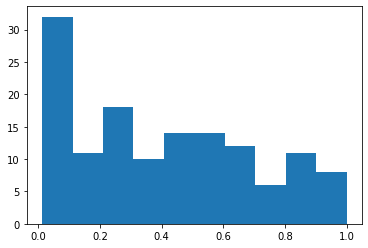

In [152]:
plt.hist(np.array(mz_close)[:, 3].astype('float'))

In [93]:
set(rt_close) & set(mz_close)

{('LysoPC_18:0_524.37164_2.502', 8),
 ('LysoPC_20:2_548.37134_2.003', 430),
 ('unknown_565.3631_2.511', 59)}

In [ ]:
same_pol = []

In [33]:
np.isclose(1000.0, 999.999, atol=0, rtol=10 * 1e-6)

True

In [17]:
metab

,20210831_KAO_HILIC_T112M_20210330_8wk_RBG,20210831_KAO_HILIC_T193M20210406_9wk_RBG,20210831_KAO_HILIC_T1060M_20210322_8wk_FBG,20210831_KAO_HILIC_T1060M_20210325_8wk_RBG,20210831_KAO_HILIC_T1060M_20210329_9wk_FBG,20210831_KAO_HILIC_T1060M_20210401_9wk_RBG,20210831_KAO_HILIC_T1060M_20210405_10wk_FBG,20210831_KAO_HILIC_T1060M_20210408_10wk_RBG,20210831_KAO_HILIC_T1062M_20210322_8wk_FBG,20210831_KAO_HILIC_T1062M_20210325_8wk_RBG,...,Peak Rating: 20210831_KAO_HILIC_T1101M_20210330_8wk_RBG.raw (F59),Peak Rating: 20210831_KAO_HILIC_T1101M_20210402_9wk_FBG.raw (F60),Peak Rating: 20210831_KAO_HILIC_T1101M_20210406_9wk_RBG.raw (F61),Peak Rating: 20210831_KAO_HILIC_T1101M_20210410_10wk_FBG.raw (F62),Peak Rating: 20210831_KAO_HILIC_T1101M_20210413_10wk_RBG.raw (F63),Peak Rating: 20210831_KAO_HILIC_T1102M_20210327_8wk_FBG.raw (F64),Peak Rating: 20210831_KAO_HILIC_T1102M_20210402_9wk_FBG.raw (F65),Peak Rating: 20210831_KAO_HILIC_T1102M_20210406_9wk_RBG.raw (F66),Peak Rating: 20210831_KAO_HILIC_T1102M_20210410_10wk_FBG.raw (F67),Peak Rating: 20210831_KAO_HILIC_T1102M_20210413_10wk_RBG.raw (F68)
0,31.265646,31.367784,31.408931,31.489706,31.415791,31.361736,31.416008,31.612634,31.445632,31.497140,...,5.7,3.5,1.3,4,5.1,4.6,6.7,6.2,NaN,4.6
176,30.624453,30.644187,30.560702,30.610134,30.606110,30.996475,29.787913,30.636811,30.572489,30.636650,...,6.2,5.7,NaN,NaN,6.2,NaN,6.2,NaN,5.7,NaN
313,29.689560,29.774822,29.945500,29.309067,30.082627,29.431175,30.096643,29.270487,30.703658,30.109212,...,8.4,7.8,8.4,9.5,9.5,10,8.9,9.5,8.4,7.8
501,29.931633,29.942531,29.528341,29.827946,29.599444,30.018239,29.253402,29.673409,29.569621,30.189935,...,6.2,8.4,8.9,8.4,7.8,8.4,8.4,7.8,8.4,8.4
698,28.978826,29.128997,29.839308,28.459047,30.235353,28.625995,30.252208,28.265490,30.641931,29.492769,...,8.4,8.4,8.9,8.4,9.5,9.5,9.5,9.5,7.8,7.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127732,19.698029,19.891287,17.763246,19.627882,19.473107,18.243526,19.477656,19.609624,19.345424,19.619823,...,7.4,0.3,6.8,0.3,NaN,0.3,NaN,6.8,0.3,6.8
127827,20.058637,19.564824,19.261637,19.559839,18.631130,20.407732,19.581830,19.719846,19.717326,19.575585,...,7.4,0.3,5.8,3.4,NaN,7.9,6.8,3,6.8,7.4
127925,17.444434,19.490645,19.101047,20.183049,19.537407,16.575568,18.931378,19.504332,19.888199,18.929660,...,NaN,7.4,NaN,NaN,NaN,7.9,0.3,7.9,7.4,NaN
127984,19.294282,18.659783,20.034384,19.589771,20.037159,19.774595,20.258819,18.942582,19.854122,18.940518,...,7.9,0.3,NaN,0.3,0.3,0.3,6.3,8.5,7.9,0.3


In [301]:
from urllib.request import urlretrieve
gh = "https://raw.githubusercontent.com/OpenMS/pyopenms-docs/master"
urlretrieve (gh + "/src/data/FeatureFinderCentroided_1_input.mzML", "feature_test.mzML")

from pyopenms import (
    PeakFileOptions, MzMLFile, MSExperiment, 
    FeatureFinder, FeatureMap, FeatureDeconvolution, FeatureXMLFile
)

# Prepare data loading (save memory by only
# loading MS1 spectra into memory)
options = PeakFileOptions()
options.setMSLevels([1])
fh = MzMLFile()
fh.setOptions(options)

# Load data
input_map = MSExperiment()
fh.load("feature_test.mzML", input_map)
input_map.updateRanges()

ff = FeatureFinder()
ff.setLogType(LogType.CMD)

# Run the feature finder
name = "centroided"
features = FeatureMap()
seeds = FeatureMap()
params = FeatureFinder().getParameters(name)
ff.run(name, input_map, features, params, seeds)

features.setUniqueIds()
fh = FeatureXMLFile()
fh.store("output.featureXML", features)
print("Found", features.size(), "features")

Found 17 features


In [302]:
seeds.

In [299]:
for f in features:
#     print(f)
    print(f.getIntensity())
    print(f.getMZ())
    print('\n')

50428.71875
646.2401845614284


43988.75
648.2566249146253


35734.03125
651.7584805382761


20430.125
653.7719682947396


13496.3310546875
652.7658776567814


10589.2685546875
654.2553909844328


8345.6240234375
646.7653201639009


7521.41064453125
654.7797109987076


6812.61865234375
644.254453808198


5546.337890625
656.2585508503842


5112.1123046875
648.772621235014


3995.6259765625
648.264184102661


3115.05859375
647.2437546308577


2887.807373046875
643.24404040104


2817.2060546875
657.2396171904916


2792.348388671875
655.7744821416368


2587.462890625
655.759298123772




In [447]:
l = []
with open(r'..\data\raw\raw_spectrum_blob_cdresults_file.bin', mode='rb') as f:
    for line in f.read():
        l.append(line)

ValueError: binary mode doesn't take an encoding argument

In [433]:
import codecs

decode_hex = codecs.getdecoder("hex_codec")

# for an array
msgs = [decode_hex(msg)[0] for msg in msgs]

# for a string
string = decode_hex(string)[0]

NameError: name 'msgs' is not defined

In [ ]:
import numpy as np


In [559]:
for offset in range(100):
    file_content = np.fromfile(r'..\data\raw\raw_spectrum_blob_cdresults_file.bin', 
#                                dtype='<f2', 
    #                            dtype=np.byte,
                               dtype=np.dtype('f, i4, i2'),
                               offset=offset)

    print([x for x in file_content][0:4])

[(1.5433558e-36, 20, 8), (4.1143834e+12, 1025788690, 1508), (1.6660742e-26, 1441792, 0), (4.2324072e+21, 1836413556, 13663)]
[(6.664946e-27, 134217728, 5888), (6.7032825e-28, -465755061, 5), (1.895901e-39, 5632, 29440), (7.2064745e+31, 1601009010, 13621)]
[(1.838149e-39, 524288, 32023), (9589871., 98843940, 0), (7.406e-42, 22, 28787), (4.8406082e+30, 895446389, 12597)]
[(7.18e-42, 385878016, 28541), (4.4034133e-17, 386109, -23296), (1.0339782e-25, 1929379840, 25968), (3.0734776e+32, 892690285, 12849)]
[(2.8e-44, 2098659336, 21615), (0.04011066, 1508, 5285), (2.020381e-39, 1886584832, 25445), (4.747637e+27, 825570655, 11570)]
[(3.85186e-34, 1870468864, 4692), (-1.3956199e+22, -1526726651, 20), (7.892e-42, 1701868288, 29795), (1.7110708e+19, 842085685, 13613)]
[(7.34684e-40, 1416592663, 19218), (2.1463476e-35, 346357760, 0), (3.1e-44, 1667592307, 29300), (8.3233255e-07, 758264117, 13621)]
[(4.136913e-25, 307523453, 9291), (5.41054e-40, 1352960, 5632), (1.0141205e+31, 1952671088, 30066), 

[4.24731786664e-313,
 -1.302035994512548e-102,
 -5.678650999305605e-270,
 4.719655001866543e+233,
 1.3124767027288377e-51,
 2.214202087498138e-52,
 1.8685333250862395e+245,
 3.494104431077601e-270,
 -1.6859265596625266e+82,
 2.0706951298764163e+52,
 3.5932948661639925e+160,
 -0.0019392557443894704,
 -1.8055346516450546e-117,
 1.9516999641409006e+113,
 -3.083465964412091e+19,
 2.2363321088201856e+272,
 -1.1910634931584858e+61,
 -1.5973743496261841e+283,
 1.3236629780717604e-40,
 8.767664150066146e+265,
 1.5766827121882678e-81,
 -1.2642280620375706e-80,
 -1.4959924772345156e+141,
 -1.6979959108216576e+302,
 -1.221726809500235e+202,
 -2.1396736879643637e-251,
 -3.799299759699024e+267,
 -6.348890672767285e-99,
 -1.2426335667799494e+308,
 -3.060845273067167e+114,
 -7.597641439982552e-136,
 4.8464438032006407e+266,
 -2.224601523511043e+77,
 -5.6351531809643894e+187,
 -6.745762300212714e+114,
 1.9535592054258823e+236,
 -1.1517218694387553e+113,
 -1.940811363909396e+284,
 -1.8421362046804612e+